In [1]:
import pandas as pd
import numpy as np
import warnings
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
path = 'E:/Dataset/零基础入门金融风控-贷款违约预测'
train = pd.read_csv(path+'/train.csv')
test = pd.read_csv(path+'/testA.csv')

In [10]:
# 信用评分 为了可解释性，使用逻辑回归进行建模 
train.info()
   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  800000 non-null  int64  
 1   loanAmnt            800000 non-null  float64
 2   term                800000 non-null  int64  
 3   interestRate        800000 non-null  float64
 4   installment         800000 non-null  float64
 5   grade               800000 non-null  object 
 6   subGrade            800000 non-null  object 
 7   employmentTitle     799999 non-null  float64
 8   employmentLength    753201 non-null  object 
 9   homeOwnership       800000 non-null  int64  
 10  annualIncome        800000 non-null  float64
 11  verificationStatus  800000 non-null  int64  
 12  issueDate           800000 non-null  object 
 13  isDefault           800000 non-null  int64  
 14  purpose             800000 non-null  int64  
 15  postCode            799999 non-nul

[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.725099
[200]	valid_0's auc: 0.727166
[300]	valid_0's auc: 0.727457
[400]	valid_0's auc: 0.727639
[500]	valid_0's auc: 0.727699
Early stopping, best iteration is:
[489]	valid_0's auc: 0.727755


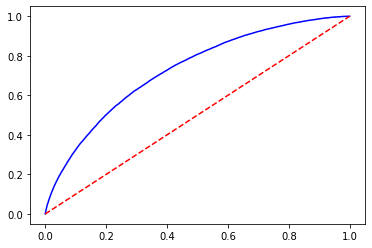

In [14]:
from sklearn.model_selection import KFold

X_train = train.drop(['id', 'issueDate', 'isDefault', 'grade',
                      'subGrade','employmentLength', 'issueDate','earliesCreditLine'], axis=1)
y_train = train['isDefault']

# 5折验证法
folds = 5
seed = 42
kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

from sklearn.model_selection import train_test_split
import lightgbm as lgb

X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2)
train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
valid_matrix = lgb.Dataset(X_val, label=y_val)

params = {
    'boosting_type': 'gbdt',
            'objective': 'binary',
            'learning_rate': 0.1,
            'metric': 'auc',
            'min_child_weight': 1e-3,
            'num_leaves': 31,
            'max_depth': -1,
            'reg_lambda': 0,
            'reg_alpha': 0,
            'feature_fraction': 1,
            'bagging_fraction': 1,
            'bagging_freq': 0,
            'seed': 2020,
            'nthread': 8,
            'silent': True,
            'verbose': -1,
}

model = lgb.train(params, train_set=train_matrix, valid_sets=valid_matrix, num_boost_round=2000, verbose_eval=100, early_stopping_rounds=100)

from sklearn import metrics
from sklearn.metrics import roc_auc_score

val_pred_lgb = model.predict(X_val, num_iteration=model.best_iteration)
fpr, tpr, threshold = metrics.roc_curve(y_val, val_pred_lgb)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.4f' % roc_auc)
plt.plot([0, 1], [0,1], 'r--')
plt.show()

In [16]:
# 模型调参的顺序
# ①：max_depth、num_leaves
# ②：min_data_in_leaf、min_child_weight
# ③：bagging_fraction、 feature_fraction、bagging_freq
# ④：reg_lambda、reg_alpha
# ⑤：min_split_gain

from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier

LGBMClassifier()
# https://tianchi.aliyun.com/notebook-ai/detail?postId=129322

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)